# Define functions

In [3]:
# Try s1+1*s2
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import os.path as osp
from scores import score_1, score_2, score_3, score_all

random.seed(999)
torch.manual_seed(999)

# Parameters
start_from_scratch = False
ROOT = '.'
save_dir = 'logs'
workers = 2
batch_size = 128
nc = 3 # Number of channels for images
nz = 256 # Size of input in generator
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode
num_epochs = 1 # Number of training epochs
gamma = 0.8
idx = 1

def load_data(root='.'):
    """
    Load test data.
    Returns:
        X_test: torch.Tensor of shape (|X|, 32, 32, 3), hold-out real samples.
        Z_test: torch.Tensor of shape (|Z|, 256), hold-out test noise samples.
    """
    X_test = torch.load(osp.join(root, 'X.pt'))
    Z_test = torch.load(osp.join(root, 'Z.pt'))
    return X_test, Z_test

def plot_GD(G_losses, D_losses, comment=' '):
    # Plot G and D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training " + comment)
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_scores(s1, s2):
    # Plot G and D losses
    plt.figure(figsize=(10,5))
    plt.title("s1 and s2 trends")
    plt.plot(s1,label="s1")
    plt.plot(s2,label="s2")
#     plt.plot(s3,label="s3")
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend()
    plt.show()

def save_loss(filename, losses, idx):
    if idx == 0:
        write_or_append = 'w'
    else:
        write_or_append = 'a'
    with open(osp.join(ROOT, save_dir, filename), write_or_append) as f:
        for loss in losses:
            f.write(str(loss) +"\n")
            
def load_loss(filename):
    # To load losses
    losses = []
    with open(osp.join(ROOT, save_dir, filename), "r") as f:
        for line in f:
            losses.append(float(line.strip()))
    return losses

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False), # nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False), # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Load and pre-process data

X shape: torch.Size([22228, 3, 32, 32]) Z shape: torch.Size([22228, 256])


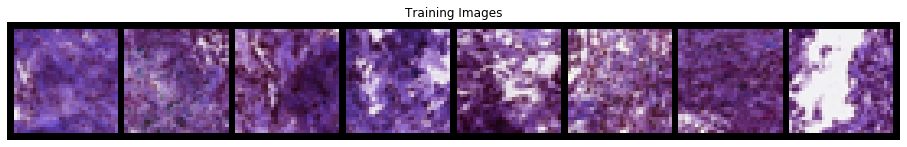

In [2]:
# X, Z = load_data()
# X = X.permute(0,3,1,2)
# X = X*2/255-1
# print('X shape:', X.shape,'Z shape:', Z.shape)

# train_data = []
# for i in range(len(X)):
#     train_data.append([X[i]])

# dataloader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=workers)

# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(16,16))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)));

# Create G and D model

if start_from_scratch = True, create G and D with random weights

else, load G and D from saved model

In [6]:
# if start_from_scratch:
#     # Start from scratch
#     idx = 0
#     with open(osp.join(ROOT, save_dir, 'idx_{}.txt'.format(gamma)), 'w') as f:
#         f.write(str(idx))

#     # Create the generator
#     netG = Generator(ngpu).to(device)
#     if (device.type == 'cuda') and (ngpu > 1):
#         netG = nn.DataParallel(netG, list(range(ngpu)))
#     netG.apply(weights_init)

#     # Create the Discriminator
#     netD = Discriminator(ngpu).to(device)
#     if (device.type == 'cuda') and (ngpu > 1):
#         netD = nn.DataParallel(netD, list(range(ngpu)))
#     netD.apply(weights_init)
# else:
#     # For subsequent runs, continue from the saved model
    
#     # Load checkpoint models
#     with open(osp.join(ROOT, save_dir, 'idx_{}.txt'.format(gamma)), "r") as f:
#         for line in f:
#             idx = int(line)

#     netD = Discriminator(ngpu).to(device)
#     netG = Generator(ngpu).to(device)

#     # Load previous models
#     netD.load_state_dict(torch.load(osp.join(ROOT, save_dir, 'D_model_{}_{}'.format(idx-1,gamma))))
#     netG.load_state_dict(torch.load(osp.join(ROOT, save_dir, 'G_model_{}_{}'.format(idx-1,gamma))))

# Define loss functions, optimizers

In [2]:
# # Loss/labels/test data/optimizers
# def boundary_loss(inp, target):
#     loss = -((1-target)*torch.log(1-4*(inp-0.5)**2))
#     return loss.mean()

# criterion = nn.BCELoss() # Loss function

# real_label = 1
# fake_label = 0

# fixed_noise = Z[:8][:,:,None,None].to(device) # For testing

# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# # Training Loop
# start = time.time()
# img_list = []
# G_losses = []
# D_losses = []
# s1 = []
# s2 = []
# # s3 = [] #---------------

# Start training proces (One additional epoch is runned for visualization purpose)

[0/1][0/174]	Loss_D: 0.0988	Loss_G: 0.6561	D(x): 0.9998	D(G(z)): 0.3298 (from D)/ 0.5189 (from G)
[0/1][50/174]	Loss_D: 0.0001	Loss_G: 0.7424	D(x): 1.0000	D(G(z)): 0.5049 (from D)/ 0.4760 (from G)
[0/1][100/174]	Loss_D: 0.0021	Loss_G: 0.6191	D(x): 1.0000	D(G(z)): 0.4750 (from D)/ 0.5384 (from G)
[0/1][150/174]	Loss_D: 0.0736	Loss_G: 0.4421	D(x): 0.9993	D(G(z)): 0.3525 (from D)/ 0.6427 (from G)
Epoch  0 	Time  1.3582664767901103
s1 :  0.9982962608337402 	s2 :  0.9999310374259949


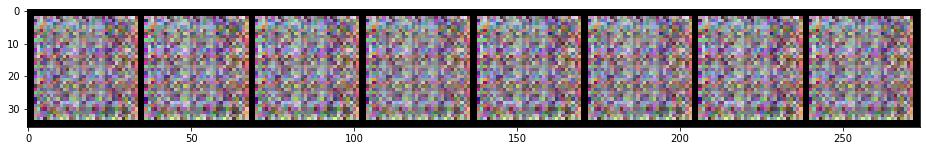

In [7]:
# for epoch in range(num_epochs):
#     # For each batch in the dataloader
#     for i, data in enumerate(dataloader): # Data shape: 128,3,32,32
        
#         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label, device=device)
#         # Forward pass real batch through D
#         output = netD(real_cpu).view(-1)
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = Z[i*128:(i+1)*128][:,:,None,None].to(device)
#         # Generate fake image batch with G
#         fake = netG(noise)
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         errD_fake = boundary_loss(output, label)
#         # Calculate the gradients for this batch
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         errD = errD_real+gamma*errD_fake
#         # Update D
#         optimizerD.step()

#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update G
#         optimizerG.step()

#         # Output training stats
#         if i % 50 == 0:            
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f (from D)/ %.4f (from G)'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

#         # Save Losses for plotting later
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())
        
#     for i, data in enumerate(dataloader): # Data shape: 128,3,32,32
#         netD.zero_grad()
#         real_cpu = data[0].to(device)
#         noise = Z[i*128:(i+1)*128][:,:,None,None].to(device)
        
#         # For score_1 and score_2 and score 3
#         img_noise = netG(noise).detach()        
#         if i == 0:
#             Dx = netD(real_cpu).view(-1).detach()
#             Dgz = netD(img_noise).view(-1).detach()
# #             img_z = img_noise #---------------
#         else:
#             Dx = torch.cat((Dx,netD(real_cpu).view(-1).detach()),0)
#             Dgz = torch.cat((Dgz, netD(img_noise).view(-1).detach()),0).detach()
# #             img_z = torch.cat((img_z,img_noise),0) #---------------
        
#     # View temporary results
#     print('Epoch ', epoch, '\tTime ',(time.time()-start)/60)
#     s1.append(score_1(Dx))
#     s2.append(score_2(Dgz))
    
#     # Record s3 only last epoch
# #     gzs = ((img_z+1)/2).permute(0,2,3,1).to(device) #---------------
# #     X_test = ((X+1)/2).permute(0,2,3,1).to(device) #---------------
# #     s3.append(score_3(X_test, gzs)) #---------------
    
#     print('s1 : ', s1[-1], '\ts2 : ', s2[-1])

#     # Check how the generator is doing by saving G's output on fixed_noise
#     with torch.no_grad():
#         fake = netG(fixed_noise).detach().cpu()
#     img = vutils.make_grid(fake, padding=2, normalize=True)
#     fig = plt.figure(figsize=(16,16))
#     plt.imshow(np.transpose(img,(1,2,0)), animated=True)
#     plt.show()
#     img_list.append(img)

# Save losses and models

In [8]:
# # For generator
# save_loss('G_losses{}.txt'.format(gamma), G_losses, idx)
# torch.save(netG.state_dict(), osp.join(ROOT, save_dir, 'G_model_{}_{}'.format(idx, gamma))) # Save G model\

# # For discriminator
# save_loss('D_losses{}.txt'.format(gamma), D_losses, idx)
# torch.save(netD.state_dict(), osp.join(ROOT, save_dir, 'D_model_{}_{}'.format(idx,gamma))) # Save D model

# # Save scores
# save_loss('s1_{}.txt'.format(gamma), s1, idx)
# save_loss('s2_{}.txt'.format(gamma), s2, idx)
# # save_loss('s3.txt', s3, idx) #---------------

# # Update number of checkpoints (idx)
# with open(osp.join(ROOT, save_dir, 'idx_{}.txt'.format(gamma)), 'w') as f:
#     f.write(str(idx+1))

# G loss/D loss/s1/s2 trends during GAN's training

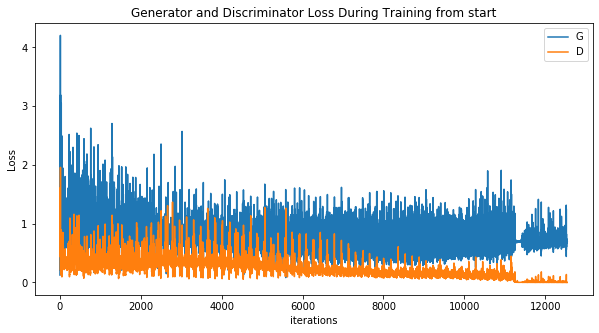

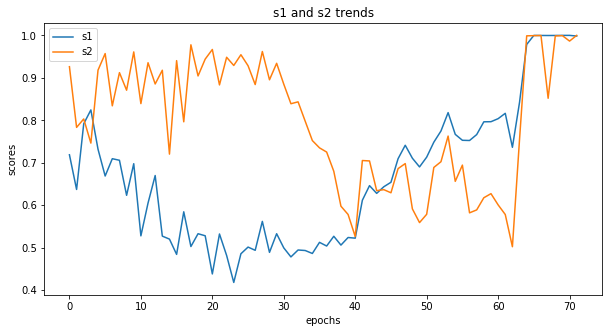

In [4]:
G_l = load_loss('G_losses{}.txt'.format(gamma))
D_l = load_loss('D_losses{}.txt'.format(gamma))
s1 = load_loss('s1_{}.txt'.format(gamma))
s2 = load_loss('s2_{}.txt'.format(gamma))
# s3 = load_loss('s3.txt') #---------------
    
# Plot total G and D loss trend from start
plot_GD(G_l, D_l, 'from start')
plot_scores(s1, s2)
# plot_scores(s1, s3) #---------------

# Generate Final Scores

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netD = Discriminator(ngpu).to(device)
netG = Generator(ngpu).to(device)

# Load previous models
idx = 1
netD.load_state_dict(torch.load(osp.join(ROOT, save_dir, 'D_model_{}_{}'.format(idx,gamma))))
netG.load_state_dict(torch.load(osp.join(ROOT, save_dir, 'G_model_{}_{}'.format(idx,gamma))))

X, Z = load_data()
X = X.permute(0,3,1,2)
X = X*2/255-1

train_data = []
for i in range(len(X)):
    train_data.append([X[i]])

dataloader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size, num_workers=workers)

D_x = []

for i, data in enumerate(dataloader):
    real_cpu = data[0].to(device)    
    if i == 0:
        D_x = netD(real_cpu).view(-1).detach()
    else:
        D_x = torch.cat((D_x,netD(real_cpu).view(-1).detach()),0)
        
for i in range(int(len(X)/128)+1):
    noise = Z[i*128:(i+1)*128][:,:,None,None].to(device)
    
    img_noise = netG(noise).detach()
    if i == 0:
        D_gx = netD(img_noise).view(-1).detach()
        img_z = img_noise
    else:
        D_gx = torch.cat((D_gx,netD(img_noise).view(-1).detach()),0).detach()
        img_z = torch.cat((img_z,img_noise),0)


X_test = ((X+1)/2).permute(0,2,3,1).to(device)
gzs = ((img_z+1)/2).permute(0,2,3,1).to(device)
disc_scores_x = D_x
disc_scores_gz = D_gx

print('Calculating scores...')
score = score_all(X_test, gzs, disc_scores_x, disc_scores_gz)
print(score)

Calculating scores...
{'s1': 0.9982962608337402, 's2': 0.9999310374259949, 's3': 0.6801146268844604, 'score': 0.6789090664113528}


# Example of generated images

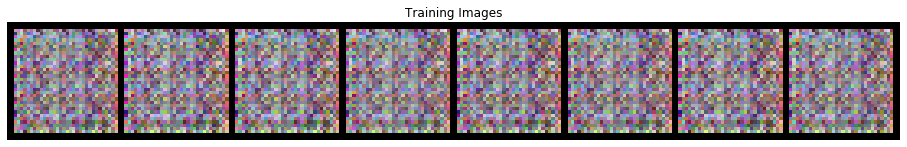

In [11]:
# Plot some training images
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(gzs[:8].permute(0,3,1,2), padding=2, normalize=True).cpu(),(1,2,0)));